In [1]:
import sys
sys.path.append("/home/user/relax/python")

In [12]:
from skimage import io, color
import matplotlib.pyplot as plt
import numpy as np

import tvm
from tvm import relay
from tvm.contrib import graph_executor

from tvm.relay import Call
from tvm import relax, tir
from tvm.relax.testing import nn
from tvm.script import relax as R

from PIL import Image

from tvm.relax.testing import from_relay

In [3]:
lenna_url = "http://www.lenna.org/lena_std.tif"

In [6]:
def read_image(url):
  image = io.imread(url)
  return image

def display_image(data):
  plt.figure()
  if len(data.shape) == 3:
    plt.imshow(data)
  else:
    assert(len(data.shape) == 2)
    plt.imshow(data[:, :], cmap=plt.cm.gray)
  
def rgb2gray(data):
  gray = color.rgb2gray(data)
  return gray

<class 'numpy.ndarray'>


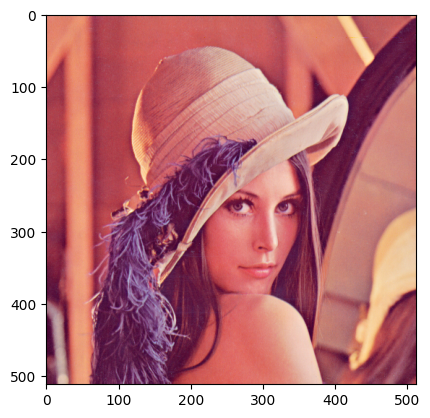

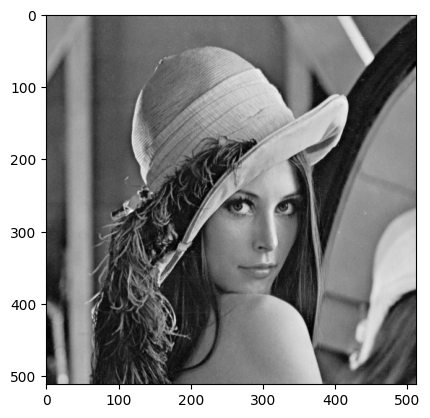

In [7]:
rgb_img = read_image(lenna_url)
display_image(rgb_img)

data = gray_img = rgb2gray(rgb_img)
print(type(data))
display_image(data)

In [8]:
def get_filter(dtype="float32"):
  sobelv = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=dtype)
  sobelh = sobelv.transpose()
  sobel = np.array((sobelh, sobelv))
  sobel = np.expand_dims(sobel, axis=3)
  sobel = sobel.transpose(1, 2, 3, 0)
  return sobel

def get_model(input_shape, dtype="float32"):                          
  filter = get_filter(dtype)
  input = tvm.relay.var("input", shape=input_shape, dtype=dtype)
  weight = tvm.relay.var("weight", shape=filter.shape, dtype=dtype)
  D = relay.nn.conv2d(input, weight, padding=(1, 1), data_layout="NHWC", kernel_layout="HWIO", out_dtype=dtype)
                                                                          
  mod = relay.Function([input, weight], D)
  params = {       
      "weight": tvm.nd.array(filter)                                     
  }         
  return mod, params

def expand_image_dims(data):
    assert(len(data.shape) == 2)
    return np.expand_dims(data, axis=(0, 3))

In [9]:
data = expand_image_dims(data)
mod, params = get_model(data.shape)
print(mod)  

conv2d NHWC layout is not optimized for x86 with autotvm.


fn (%input: Tensor[(1, 512, 512, 1), float32], %weight: Tensor[(3, 3, 1, 2), float32]) {
  nn.conv2d(%input, %weight, padding=[1, 1, 1, 1], data_layout="NHWC", kernel_layout="HWIO", out_dtype="float32")
}


conv2d NHWC layout is not optimized for x86 with autotvm.


1.40725 ms



In [10]:
with tvm.transform.PassContext(opt_level=3):           
        lib = relay.build(mod, target="llvm", params=params)
dev = tvm.device("llvm", 0)
gmod = graph_executor.GraphModule(lib["default"](dev))
gmod.set_input(**params)
gmod.set_input("input", data)
num_iter = 10
time_f = gmod.module.time_evaluator("run", dev, number=num_iter)
cost = time_f().mean 
print("%g ms\n" % (cost * 1000)) 

conv2d NHWC layout is not optimized for x86 with autotvm.
conv2d NHWC layout is not optimized for x86 with autotvm.


2.05115 ms



In [13]:
target = tvm.target.Target("llvm", host="llvm")
relax_mod = from_relay(mod, target)
relax_mod.show()
ex = relax.vm.build(relax_mod, target)
vm = relax.VirtualMachine(ex, tvm.cpu())
data = data.astype("float32")
data_nd = tvm.nd.array(data)
params_nd = {k: tvm.nd.array(v) for k, v in params.items()}
params = [data_nd, params['weight']]
print(data_nd.dtype)

/home/user/relax/python/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


float32


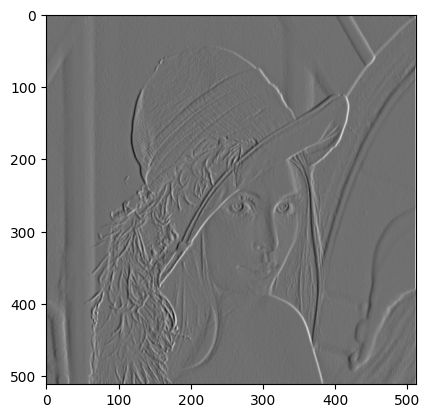

In [14]:
res = vm["main"](*params)
res = res.asnumpy() 
display_image(res[0, :, :, 0])